### 🏥 고양이 의료 문서 분석

고양이 의료 문서 분석 단계

- 전처리 > TrOCR

### 1. 환경 설정 및 라이브러리 로드

In [ ]:
# TrOCR 및 관련 라이브러리 설치
%pip install transformers torch torchvision
%pip install Pillow requests

# 기존 라이브러리도 유지 (전처리용)
%pip install pytesseract pymupdf opencv-python

# 성능 향상을 위한 추가 라이브러리 (선택사항)
%pip install accelerate  # 메모리 최적화
%pip install datasets    # 데이터셋 처리 (필요시)

# 한국어 텍스트 처리 개선용 (선택사항)
%pip install konlpy      # 한국어 자연어 처리

In [47]:
def check_trocr_setup():
    """TrOCR 설치 및 모델 로드 확인"""
    try:
        print("🔧 TrOCR 설치 확인 중...")
        
        # 필수 라이브러리 임포트 확인
        import torch
        import transformers
        from transformers import TrOCRProcessor, VisionEncoderDecoderModel
        from PIL import Image
        
        print(f"✅ PyTorch 버전: {torch.__version__}")
        print(f"✅ Transformers 버전: {transformers.__version__}")
        print(f"✅ CUDA 사용 가능: {torch.cuda.is_available()}")
        
        # CPU 사용 설정
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"🖥️ 사용 디바이스: {device}")
        
        # 모델 다운로드 테스트 (소형 모델부터)
        print("\n📥 TrOCR 모델 다운로드 테스트...")
        
        # 1. 기본 영어 모델 (가장 빠름)
        try:
            processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
            model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
            model.to(device)
            print("✅ 영어 기본 모델 로드 성공")
        except Exception as e:
            print(f"❌ 영어 기본 모델 로드 실패: {e}")
            return False
        
        # 2. 한국어 지원 다국어 모델 (느리지만 한국어 가능)
        try:
            # 다국어 모델 - 한국어 포함
            processor_multi = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
            model_multi = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
            model_multi.to(device)
            print("✅ 다국어 모델 로드 성공")
        except Exception as e:
            print(f"⚠️ 다국어 모델 로드 실패: {e}")
        
        print("\n🎯 TrOCR 설치 완료!")
        return True
        
    except ImportError as e:
        print(f"❌ 라이브러리 임포트 실패: {e}")
        print("💡 다음 명령어로 설치하세요:")
        print("   !pip install transformers torch torchvision Pillow")
        return False
    except Exception as e:
        print(f"❌ TrOCR 설정 오류: {e}")
        return False

# 설치 확인 실행
check_trocr_setup()

🔧 TrOCR 설치 확인 중...
✅ PyTorch 버전: 2.8.0+cu128
✅ Transformers 버전: 4.57.0
✅ CUDA 사용 가능: False
🖥️ 사용 디바이스: cpu

📥 TrOCR 모델 다운로드 테스트...


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ 영어 기본 모델 로드 성공


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ 다국어 모델 로드 성공

🎯 TrOCR 설치 완료!


True

In [48]:
import torch
import os

# CPU 최적화 설정
def optimize_cpu_performance():
    """CPU 성능 최적화 설정"""
    # CPU 코어 수에 맞게 스레드 설정
    cpu_count = os.cpu_count()
    torch.set_num_threads(cpu_count)
    
    print(f"🖥️ CPU 코어 수: {cpu_count}")
    print(f"🔧 PyTorch 스레드 수: {torch.get_num_threads()}")
    
    # 메모리 효율성을 위한 설정
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    print("✅ CPU 최적화 설정 완료")

optimize_cpu_performance()

🖥️ CPU 코어 수: 20
🔧 PyTorch 스레드 수: 20
✅ CPU 최적화 설정 완료


### 2. 업로드 파일 전처리

In [49]:
import io
from re import T
from typing import List, Dict, Any, Tuple, Callable, Sequence, Optional
import fitz
import tempfile
from PIL import Image, ImageFilter, ImageOps

import numpy as np
from pytesseract import image_to_data, Output
import cv2 

# ---------- 공통 보조 ----------
def _pil_to_cv(img: Image.Image) -> np.ndarray:
    arr = np.array(img)
    if arr.ndim == 2:
        return arr
    if arr.shape[2] == 4:
        # RGBA -> RGB
        arr = cv2.cvtColor(arr, cv2.COLOR_RGBA2RGB) if cv2 is not None else arr[:, :, :3]
    # RGB -> BGR
    return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR) if cv2 is not None else arr[:, :, ::-1]

def _cv_to_pil(arr: np.ndarray) -> Image.Image:
    if arr.ndim == 2:
        return Image.fromarray(arr)
    # BGR -> RGB
    if cv2 is not None:
        arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
    else:
        arr = arr[:, :, ::-1]
    return Image.fromarray(arr)

def _order_quad(pts: np.ndarray) -> np.ndarray:
    # pts: (4,2)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1).ravel()
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]
    return np.array([tl, tr, br, bl], dtype=np.float32)

def pdf_to_images(pdf_path: str, resolution_scale: float = 1.5) -> List[bytes]:
    """
    PDF 파일 경로를 받아 각 페이지를 PNG 바이트로 변환해 리스트로 반환
    """
    png_list: List[bytes] = []
    doc = None
    try:
        doc = fitz.open(pdf_path)
        mat = fitz.Matrix(resolution_scale, resolution_scale)
        for page in doc:
            pix = page.get_pixmap(matrix=mat, alpha=False)
            png_list.append(pix.tobytes("png"))
    finally:
        try:
            if doc is not None:
                doc.close()
        except Exception:
            pass
    return png_list

# ---------- 로드+EXIF 회전 교정 ----------
def open_with_exif(img_bytes: bytes):
    """
    1) 로드 + EXIF 회전 교정: 카메라 회전 정보가 있으면 실제 픽셀을 회전
    """
    img = Image.open(io.BytesIO(img_bytes))
    try:
        img = ImageOps.exif_transpose(img)
    except Exception:
        pass
    return img

# ---------- 투명 채널 플래튼 ----------
def flatten_transparency(img: Image.Image) -> Image.Image:
    """
    2) 투명 채널 플래튼: RGBA/LA → 흰 배경 위에 합성 (기호/점 주변 헤일로 방지)
    """
    if img.mode in ("RGBA", "LA"):
        bg = Image.new("RGB", img.size, (255, 255, 255))
        alpha = img.split()[-1]
        return Image.composite(img.convert("RGB"), bg, alpha)
    return img

# ---------- 여백 기반 자동 크롭 ----------
def auto_crop_with_margin(img: Image.Image, margin: int = 10) -> Image.Image:
    """
    3) 자동 크롭: 흰 배경을 기준으로 내용물 bbox를 찾고 margin만큼 여유
    """
    gray = img.convert("L")
    inv = ImageOps.invert(gray)  # 흰색 배경 → 0, 잉크 → 양수
    bbox = inv.getbbox()
    if not bbox:
        return img
    x0, y0, x1, y1 = bbox
    x0 = max(0, x0 - margin)
    y0 = max(0, y0 - margin)
    x1 = min(img.width,  x1 + margin)
    y1 = min(img.height, y1 + margin)
    return img.crop((x0, y0, x1, y1))

# ---------- 문서 외곽 사변형 경계 탐지 ----------
def detect_document_quad(img: Image.Image, min_area_ratio: float = 0.2, debug: bool = False) -> Optional[List[Tuple[int, int]]]:
    """
    new detect_document_quad(문서 외곽 사변형 경계 탐지)
    - 성공 시 좌상, 우상, 우하, 좌하 4점 반환, 실패 시 None
    """
    if cv2 is None:
        if debug: print("[detect_document_quad] OpenCV 미설치 - 건너뜀")
        return None
    im = _pil_to_cv(img)
    h, w = im.shape[:2]
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) if im.ndim == 3 else im
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(gray, 50, 150)
    edges = cv2.dilate(edges, np.ones((5,5), np.uint8), iterations=1)
    cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    img_area = w*h
    for c in cnts[:8]:
        area = cv2.contourArea(c)
        if area < img_area * min_area_ratio:
            continue
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            quad = approx.reshape(-1, 2).astype(np.float32)
            quad = _order_quad(quad)
            if debug: print(f"[detect_document_quad] 사변형 발견 - area ratio={area/img_area:.2f}")
            return [(int(x), int(y)) for x, y in quad]
    if debug: print("[detect_document_quad] 사변형 미발견")
    return None

# ---------- 사변형 → 직사각 투시 보정 ----------
def perspective_unwarp(img: Image.Image, quad: Optional[List[Tuple[int,int]]] = None, keep_aspect: bool = True, padding: int = 0, debug: bool = False) -> Image.Image:
    """
    new perspective_unwarp(사변형 → 직사각 투시 보정)
    - quad가 없으면 자동 검출을 시도
    """
    if cv2 is None:
        if debug: print("[perspective_unwarp] OpenCV 미설치 - 원본 반환")
        return img
    if quad is None:
        quad = detect_document_quad(img, debug=debug)
    if quad is None:
        if debug: print("[perspective_unwarp] 경계 미검출 - 원본 반환")
        return img

    im = _pil_to_cv(img)
    h, w = im.shape[:2]
    src = np.array(quad, dtype=np.float32)

    # 목표 크기 추정
    tl, tr, br, bl = src
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    dst_w = int(max(widthA, widthB))
    dst_h = int(max(heightA, heightB))
    if keep_aspect and dst_w > 0 and dst_h > 0:
        aspect = dst_w / (dst_h + 1e-6)
        # 의료 양식(세로형)이 흔해 약간의 정규화
        if aspect < 0.6:  # 너무 세로 길면 살짝 보정
            dst_w = int(dst_h * 0.7)

    dst = np.array([[0,0],[dst_w-1,0],[dst_w-1,dst_h-1],[0,dst_h-1]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(im, M, (dst_w, dst_h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    if padding > 0:
        warped = cv2.copyMakeBorder(warped, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=(255,255,255))
    if debug: print(f"[perspective_unwarp] 완료 → {dst_w}x{dst_h}")
    return _cv_to_pil(warped)

# ---------- OSD + 텍스트 라인 기반 미세 기울기 보정 ----------
def deskew_textlines(
    img: Image.Image,
    max_angle: float = 12.0,
    refine: bool = True,
    refine_range: float = 1.2,   # ± 탐색 범위(도)
    refine_step: float = 0.05,   # 탐색 간격(도)
    pad: int = 12,               # 회전 전 여백(클리핑 방지)
    debug: bool = False,
) -> Image.Image:
    """
    수평 선 강조 + Hough로 '대략 각도' 추정 후,
    작은 범위에서 행 프로젝션 점수로 정밀 탐색해 교정.
    """
    if cv2 is None:
        if debug: print("[deskew_textlines] OpenCV 미설치 - 원본 반환")
        return img

    im0 = _pil_to_cv(img)
    if pad > 0:
        im = cv2.copyMakeBorder(im0, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
    else:
        im = im0

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) if im.ndim == 3 else im
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thr = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    bw_inv = 255 - thr
    h, w = gray.shape[:2]

    # 수평 구조 강조(커널 폭 소폭 증가 → 안정적 각도 추정)
    kx = max(21, w // 30)
    hker = cv2.getStructuringElement(cv2.MORPH_RECT, (kx, 1))
    horiz = cv2.morphologyEx(bw_inv, cv2.MORPH_OPEN, hker)

    # 에지 결합
    edges = cv2.max(cv2.Canny(bw_inv, 50, 150), cv2.Canny(horiz, 50, 150))

    # 1) HoughLinesP로 대략 각도(선 길이 가중)
    min_len = max(60, int(w * 0.35))
    linesP = cv2.HoughLinesP(
        edges, 1, np.pi / 180,
        threshold=max(50, int(0.0025 * w)),
        minLineLength=min_len,
        maxLineGap=30
    )
    angles, weights = [], []
    if linesP is not None:
        for x1, y1, x2, y2 in linesP[:, 0]:
            ang = np.degrees(np.arctan2(y2 - y1, x2 - x1))
            if -max_angle <= ang <= max_angle:
                L = float(np.hypot(x2 - x1, y2 - y1))
                angles.append(ang); weights.append(L)

    # 보조: 표준 Hough
    if len(angles) < 5:
        lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=max(120, int(0.006 * w)))
        if lines is not None:
            for rho, theta in lines[:, 0]:
                ang = (theta * 180 / np.pi) - 90
                if -max_angle <= ang <= max_angle:
                    angles.append(ang); weights.append(1.0)

    coarse = float(np.average(angles, weights=weights)) if angles else 0.0
    final_angle = coarse

    # 2) 정밀 탐색(±refine_range, step=refine_step) - 행 프로젝션 점수 최대화
    if refine:
        # 속도 위해 다운스케일
        scale = 1000.0 / max(h, w)
        small = cv2.resize(bw_inv, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA) if scale < 1.0 else bw_inv
        sh, sw = small.shape[:2]

        def score(a_deg: float) -> float:
            M = cv2.getRotationMatrix2D((sw / 2, sh / 2), a_deg, 1.0)
            r = cv2.warpAffine(small, M, (sw, sh), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
            proj = r.mean(axis=1)           # 행 방향 평균(수평선이 곧을수록 변동↑)
            d = np.diff(proj)
            return float(proj.var() + 0.5 * (d * d).mean())

        best_s, best_a = -1e9, coarse
        for a in np.arange(coarse - refine_range, coarse + refine_range + 1e-9, refine_step):
            s = score(a)
            if s > best_s:
                best_s, best_a = s, a
        final_angle = best_a

    if debug:
        print(f"[deskew_textlines] coarse={coarse:.2f}°, final={final_angle:.2f}°")

    if abs(final_angle) < 0.05:
        return img

    M = cv2.getRotationMatrix2D((w / 2, h / 2), final_angle, 1.0)
    rotated = cv2.warpAffine(im, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    if pad > 0 and rotated.shape[0] > 2 * pad and rotated.shape[1] > 2 * pad:
        rotated = rotated[pad:-pad, pad:-pad]
    return _cv_to_pil(rotated)

# ---------- 페이지 말림/곡면 보정·필요 시만 ----------
def conditional_dewarp(img: Image.Image, strength: float = 0.6, min_lines: int = 10, debug: bool = False) -> Image.Image:
    """
    new conditional_dewarp(페이지 말림/곡면 보정·필요 시만)
    - HoughLinesP로 수평 라인을 샘플링하고, x에 따른 베이스라인 곡선을 2차 다항으로 근사.
    - 각 x 컬럼마다 세로 시프트 맵을 만들어 보정(간이 방식).
    """
    if cv2 is None:
        if debug: print("[conditional_dewarp] OpenCV 미설치 - 원본 반환")
        return img
    im = _pil_to_cv(img)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) if im.ndim == 3 else im
    bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 35, 15)
    lines = cv2.HoughLinesP(bw, 1, np.pi/180, threshold=100, minLineLength=max(40, gray.shape[1]//10), maxLineGap=10)
    if lines is None or len(lines) < min_lines:
        if debug: print("[conditional_dewarp] 라인 부족 - 스킵")
        return img

    pts_x, pts_y = [], []
    for l in lines[:,0]:
        x1,y1,x2,y2 = l
        # 거의 수평 라인만 사용
        if abs(y2 - y1) <= 3:
            xm = 0.5*(x1+x2)
            ym = 0.5*(y1+y2)
            pts_x.append(xm)
            pts_y.append(ym)
    if len(pts_x) < min_lines:
        if debug: print("[conditional_dewarp] 유효 수평 라인 부족 - 스킵")
        return img

    z = np.polyfit(np.array(pts_x), np.array(pts_y), deg=2)
    p = np.poly1d(z)
    h, w = gray.shape[:2]
    xs = np.arange(w, dtype=np.float32)
    curve = p(xs).astype(np.float32)
    shift = (curve - np.mean(curve)) * strength  # 각 컬럼의 세로 시프트

    map_x = np.tile(xs, (h,1)).astype(np.float32)
    ys = np.arange(h, dtype=np.float32)
    map_y = (np.tile(ys[:,None], (1,w)) - shift[None, :]).astype(np.float32)
    map_y = np.clip(map_y, 0, h-1)
    dewarped = cv2.remap(im, map_x, map_y, interpolation=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    if debug: print("[conditional_dewarp] 간이 디워프 적용")
    return _cv_to_pil(dewarped)

# ---------- 최소 해상도 확보 업스케일 ----------
def upscale_min_resolution(img: Image.Image, min_long_edge: int = 1200) -> Image.Image:
    """
    4) 해상도 표준화(업스케일만): 소수점/기호 선명도를 위해 최소 해상도 확보, 과대 크기는 축소하지 않음
    """
    w, h = img.size
    long_edge = max(w, h)
    if long_edge < min_long_edge:
        scale = min_long_edge / float(long_edge)
        img = img.resize((int(round(w * scale)), int(round(h * scale))), Image.LANCZOS)
    return img

# ---------- 배경 평탄화·그라디언트/그림자 제거 ----------
def illumination_flatten(img: Image.Image, blur_ratio: float = 0.03, debug: bool = False) -> Image.Image:
    """
    new illumination_flatten(배경 평탄화·그림자 제거)
    - 큰 가우시안 블러로 배경을 추정 후 L(밝기) 채널에서 평탄화
    """
    if cv2 is None:
        if debug: print("[illumination_flatten] OpenCV 미설치 - 원본 반환")
        return img
    im = _pil_to_cv(img)
    if im.ndim == 3:
        lab = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
        L, A, B = cv2.split(lab)
        k = max(3, int(round(max(im.shape[:2]) * blur_ratio)) | 1)
        bg = cv2.GaussianBlur(L, (k, k), 0)
        flat = cv2.normalize(cv2.subtract(L, bg) + 128, None, 0, 255, cv2.NORM_MINMAX)
        lab = cv2.merge([flat, A, B])
        out = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    else:
        k = max(3, int(round(max(im.shape[:2]) * blur_ratio)) | 1)
        bg = cv2.GaussianBlur(im, (k, k), 0)
        out = cv2.normalize(cv2.subtract(im, bg) + 128, None, 0, 255, cv2.NORM_MINMAX)
    if debug: print(f"[illumination_flatten] k={k} 적용")
    return _cv_to_pil(out)

# ---------- 하이라이트/빛반사 감쇠 ----------
def suppress_glare(img: Image.Image, v_high: int = 230, s_low: int = 40, debug: bool = False) -> Image.Image:
    """
    new suppress_glare(하이라이트/빛반사 감쇠)
    - HSV에서 S 낮고 V 높은 영역을 완만히 억제
    """
    if cv2 is None:
        if debug: print("[suppress_glare] OpenCV 미설치 - 원본 반환")
        return img
    im = _pil_to_cv(img)
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV) if im.ndim == 3 else cv2.cvtColor(cv2.cvtColor(im, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)
    mask = cv2.inRange(S, 0, s_low) & cv2.inRange(V, v_high, 255)
    # 밝기 완만 감소
    V2 = V.copy()
    V2[mask > 0] = (0.85 * V2[mask > 0]).astype(np.uint8)
    hsv2 = cv2.merge([H, S, V2])
    out = cv2.cvtColor(hsv2, cv2.COLOR_HSV2BGR)
    if debug: print("[suppress_glare] 글레어 감쇠 적용")
    return _cv_to_pil(out)

# ---------- 이미지 모드 정규화 ----------
def normalize_mode(img: Image.Image) -> Image.Image:
    """
    5) 모드 정규화: 이후 연산 호환을 위해 L 또는 RGB로 제한
    """
    if img.mode not in ("L", "RGB"):
        return img.convert("RGB")
    return img

# ---------- 약한 전역 대비 보정 ----------
def weak_autocontrast(img: Image.Image, cutoff: float = 0.4) -> Image.Image:
    """
    6) 자동 대비: 낮은 컷오프(0.4%)로 미세 픽셀(소수점·단위) 클리핑 방지
    """
    return ImageOps.autocontrast(img, cutoff=cutoff)

# ---------- 로컬 대비 향상·과도 시 비활성화 ----------
def apply_clahe(img: Image.Image, clip_limit: float = 2.0, tile_grid: Tuple[int,int] = (8,8), enabled: bool = True, debug: bool = False) -> Image.Image:
    """
    new apply_clahe(로컬 대비 향상·과도 시 비활성화)
    """
    if not enabled:
        return img
    if cv2 is None:
        if debug: print("[apply_clahe] OpenCV 미설치 - 원본 반환")
        return img
    im = _pil_to_cv(img)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid)
    if im.ndim == 3:
        lab = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
        L, A, B = cv2.split(lab)
        L2 = clahe.apply(L)
        lab2 = cv2.merge([L2, A, B])
        out = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
    else:
        out = clahe.apply(im)
    if debug: print("[apply_clahe] 적용 완료")
    return _cv_to_pil(out)

# ---------- 보수적 샤프닝 ----------
def conservative_sharpen(img: Image.Image, radius: float = 1.0, percent: int = 120, threshold: int = 3, enabled: bool = True) -> Image.Image:
    """
    7) 보수적 샤픈: 소수점 주변 헤일로 없이 스트로크만 강화
    """
    if not enabled:
        return img
    return img.filter(ImageFilter.UnsharpMask(radius=radius, percent=percent, threshold=threshold))

# ---------- 그레이스케일 변환 ----------
def to_grayscale(img: Image.Image, enabled: bool = True) -> Image.Image:
    """
    8) 그레이스케일: 문서형 이미지에서 텍스트 대비를 높여 인식 안정화
    """
    if enabled and img.mode != "L":
        return img.convert("L")
    return img

# ---------- 적응형 이진화·문서용 ----------
def adaptive_binarize_for_ocr(img: Image.Image, block_size: int = 25, k: float = 0.15, debug: bool = False) -> Image.Image:
    """
    new adaptive_binarize_for_ocr(적응형 이진화·문서용)
    - scikit-image의 Sauvola가 있으면 사용, 없으면 OpenCV 가우시안 적응 이진화
    """
    arr = _pil_to_cv(img)
    gray = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY) if (cv2 is not None and arr.ndim == 3) else (arr if arr.ndim == 2 else arr[:, :, 0])
    try:
        from skimage.filters import threshold_sauvola  # type: ignore
        win = block_size if block_size % 2 == 1 else block_size + 1
        thresh = threshold_sauvola(gray, window_size=win, k=k)
        bw = (gray > thresh).astype(np.uint8) * 255
        if debug: print("[adaptive_binarize_for_ocr] Sauvola 적용")
    except Exception:
        if cv2 is None:
            if debug: print("[adaptive_binarize_for_ocr] OpenCV/Skimage 없음 - 원본 반환")
            return img
        win = block_size if block_size % 2 == 1 else block_size + 1
        bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, win, 10)
        if debug: print("[adaptive_binarize_for_ocr] OpenCV 적응 이진화 적용")
    return Image.fromarray(bw)

# ---------- 모폴로지로 표 수평/수직 라인 약 강화 ----------
def enhance_table_lines(img: Image.Image, strength: float = 0.5, debug: bool = False) -> Image.Image:
    """
    new enhance_table_lines(모폴로지로 표 수평/수직 라인 약 강화)
    - 블랙햇(black-hat)으로 어두운 선을 강조 후 원본에서 소량 감산
    """
    if cv2 is None:
        if debug: print("[enhance_table_lines] OpenCV 미설치 - 원본 반환")
        return img
    im = _pil_to_cv(img)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) if im.ndim == 3 else im
    h, w = gray.shape[:2]
    hk = max(3, (w // 80) | 1)
    vk = max(3, (h // 80) | 1)
    hker = cv2.getStructuringElement(cv2.MORPH_RECT, (hk, 1))
    vker = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vk))
    hhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, hker)
    vhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, vker)
    comb = cv2.max(hhat, vhat)
    delta = (comb * np.clip(strength, 0.0, 1.0)).astype(np.uint8)
    enhanced = cv2.subtract(gray, delta)
    if im.ndim == 3:
        out = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
    else:
        out = enhanced
    if debug: print("[enhance_table_lines] 라인 강화 완료")
    return _cv_to_pil(out)

# ---------- TSV 앵커 기반 테이블 스마트 크롭 ----------
def table_smart_crop(
    img: Image.Image,
    enabled: bool = False,
    lang: str = "eng+kor",
    conf_min: int = 30,
    top_margin: int = 18,
    bottom_margin: int = 10,
    min_header_hits: int = 2,
    first_col_tolerance: int = 80,
    gap_multiplier: float = 2.8,
    min_rows: int = 5,
    debug: bool = True,
    min_table_height: int = 100,  # 🆕 최소 테이블 높이 파라미터
) -> Image.Image:
    """
    테이블 스마트 크롭(1순위: Tesseract TSV 앵커)
    - 상단: 헤더(국/영 키워드) 또는 바이오마커 열의 첫 클러스터 시작
    - 하단: 다음 헤더 직전 또는 큰 수직 공백(행간 중앙값*k) 직전
    - 여러 테이블이 있어도 가장 위 테이블 1개만 남김
    """
    if not enabled:
        if debug:
            print("[table_smart_crop] ⏭️ 비활성화 상태 - 원본 반환")
        return img
    
    if debug:
        print(f"[table_smart_crop] 🚀 시작 - 이미지 크기: {img.size}")
    
    try:
        pil = img if img.mode in ("L", "RGB") else img.convert("RGB")
        if debug:
            print(f"[table_smart_crop] 🖼️ 이미지 모드: {pil.mode}")

        # OCR
        if debug:
            print("[table_smart_crop] 📝 OCR 시작 (Tesseract)...")
        config = "--oem 3 --psm 4"
        data = image_to_data(pil, lang=lang, config=config, output_type=Output.DICT)
        n = len(data.get("text", []))
        if debug:
            print(f"[table_smart_crop] 📊 OCR 완료 - 총 {n}개 텍스트 요소 감지")
        
        if n == 0:
            if debug:
                print("[table_smart_crop] ⚠️ OCR 결과 없음 - 원본 반환")
            return img

        # 단어 토큰 필터링
        if debug:
            print(f"[table_smart_crop] 🔍 토큰 필터링 (최소 신뢰도: {conf_min})...")
        tokens = []
        for i in range(n):
            txt = (data["text"][i] or "").strip()
            if not txt:
                continue
            try:
                conf = float(data["conf"][i])
            except Exception:
                conf = -1
            if conf < conf_min:
                continue
            tokens.append(
                {
                    "text": txt,
                    "x": int(data["left"][i]),
                    "y": int(data["top"][i]),
                    "w": int(data["width"][i]),
                    "h": int(data["height"][i]),
                    "page": int(data["page_num"][i]),
                    "block": int(data["block_num"][i]),
                    "par": int(data["par_num"][i]),
                    "line": int(data["line_num"][i]),
                }
            )
        
        if debug:
            print(f"[table_smart_crop] ✅ 유효한 토큰: {len(tokens)}개")
        
        if not tokens:
            if debug:
                print("[table_smart_crop] ⚠️ 유효한 토큰 없음 - 원본 반환")
            return img

        # 라인 그룹핑
        if debug:
            print("[table_smart_crop] 📋 라인 그룹핑 시작...")
        from collections import defaultdict
        groups = defaultdict(list)
        for t in tokens:
            key = (t["page"], t["block"], t["par"], t["line"])
            groups[key].append(t)

        lines = []
        for key, group in groups.items():
            x0 = min(g["x"] for g in group)
            y0 = min(g["y"] for g in group)
            x1 = max(g["x"] + g["w"] for g in group)
            y1 = max(g["y"] + g["h"] for g in group)
            text_norm = " ".join(g["text"] for g in group).lower()
            lines.append({"x0": x0, "y0": y0, "x1": x1, "y1": y1, "text": text_norm})
        
        if debug:
            print(f"[table_smart_crop] ✅ 라인 그룹핑 완료: {len(lines)}개 라인")
        
        if not lines:
            if debug:
                print("[table_smart_crop] ⚠️ 라인 없음 - 원본 반환")
            return img
        
        lines.sort(key=lambda l: l["y0"])

        # 헤더 후보 판단(국/영 혼합)
        if debug:
            print("[table_smart_crop] 🔎 헤더 라인 검색 중...")
        header_kws = {
            "name", "unit", "result", "reference", "ref", "min", "max",
            "항목", "검사항목", "결과", "단위", "기준치", "참조치", "참고치"
        }
        def is_header(l) -> bool:
            hits = sum(1 for kw in header_kws if kw in l["text"])
            return hits >= min_header_hits and len(l["text"]) >= 4

        header_lines = [l for l in lines if is_header(l)]
        header_lines.sort(key=lambda l: l["y0"])
        
        if debug:
            print(f"[table_smart_crop] 📌 헤더 라인 발견: {len(header_lines)}개")
            if header_lines:
                for idx, h in enumerate(header_lines[:5]):  # 🆕 최대 5개만 출력
                    print(f"[table_smart_crop]    헤더 {idx+1}: y={h['y0']}, text='{h['text'][:50]}...'")

        # 바이오마커 앵커(헤더 실패 대비)
        if debug:
            print("[table_smart_crop] 🧬 바이오마커 검색 중...")
        biomarker_kws = {
            "rbc","hct","hgb","mcv","mch","mchc","plt","wbc",
            "retic","glucose","glu","bun","crea","creatinine","ast","alt","alp",
            "mpv","pct","rdw","neut","lymph","mono","eos","baso"
        }
        def has_biomarker(l) -> bool:
            t = l["text"].replace("−", "-")
            return any(kw in t for kw in biomarker_kws)

        # 상단 y 결정
        if header_lines:
            if debug:
                print("[table_smart_crop] ✅ 헤더 기반으로 상단 계산")
            top_header = header_lines[0]
            y_top = max(0, top_header["y0"] - top_margin)
            anchor_x = top_header["x0"]
            if debug:
                print(f"[table_smart_crop]    y_top={y_top}, anchor_x={anchor_x}")
        else:
            if debug:
                print("[table_smart_crop] 🔄 헤더 없음 - 바이오마커 앵커 사용")
            biomarker_lines = [l for l in lines if has_biomarker(l)]
            if not biomarker_lines:
                if debug:
                    print("[table_smart_crop] ❌ 바이오마커도 없음 - 원본 반환")
                return img
            
            if debug:
                print(f"[table_smart_crop] ✅ 바이오마커 라인: {len(biomarker_lines)}개")
            
            biomarker_lines.sort(key=lambda l: l["y0"])
            xs = np.array([l["x0"] for l in biomarker_lines])
            anchor_x = int(np.percentile(xs, 20))
            first_band = [l for l in biomarker_lines if abs(l["x0"] - anchor_x) <= first_col_tolerance] or biomarker_lines[:1]
            y_top = max(0, min(l["y0"] for l in first_band) - top_margin)
            if debug:
                print(f"[table_smart_crop]    y_top={y_top}, anchor_x={anchor_x}")

        # 🆕 하단 y 결정 (개선된 로직)
        if debug:
            print("[table_smart_crop] 📐 하단 경계 계산 중...")
        
        # 다음 헤더 필터링: 충분히 멀리 떨어진 헤더만 고려
        below_headers = [l for l in header_lines if l["y0"] > y_top + min_table_height]
        
        if debug:
            print(f"[table_smart_crop]    충분히 멀리 떨어진 헤더: {len(below_headers)}개 (최소 거리: {min_table_height}px)")
        
        if below_headers:
            # 다음 테이블의 헤더를 찾았다면 그 직전까지
            y_bottom = max(y_top + min_table_height, below_headers[0]["y0"] - 10)
            if debug:
                print(f"[table_smart_crop] ✅ 다음 테이블 헤더로 하단 결정: y_bottom={y_bottom}")
        else:
            # 다음 헤더가 없으면 공백 분석으로 하단 결정
            if debug:
                print("[table_smart_crop] 🔄 다음 헤더 없음 - 공백 분석으로 하단 결정")
            candidate = [l for l in lines if l["y0"] >= y_top]
            band = [l for l in candidate if abs(l["x0"] - anchor_x) <= first_col_tolerance]
            band.sort(key=lambda l: l["y0"])
            
            if debug:
                print(f"[table_smart_crop]    테이블 후보 라인: {len(band)}개")
            
            if len(band) < min_rows:
                if debug:
                    print(f"[table_smart_crop] ⚠️ 최소 행 수 부족 ({len(band)} < {min_rows})")
                    print(f"[table_smart_crop] 🔄 전체 라인에서 공백 분석 시도...")
                # 🆕 첫 열 제약 완화: 전체 라인에서 y_top 이후 모든 라인 고려
                band = [l for l in lines if l["y0"] >= y_top]
                band.sort(key=lambda l: l["y0"])
                
                if len(band) < min_rows:
                    if debug:
                        print(f"[table_smart_crop] ❌ 전체 라인도 부족 ({len(band)} < {min_rows}) - 원본 반환")
                    return img
            
            gaps = [band[i+1]["y0"] - band[i]["y1"] for i in range(len(band)-1)]
            med_gap = np.median([g for g in gaps if g >= 0]) if gaps else 20
            thresh = max(24, med_gap * gap_multiplier)
            
            if debug:
                print(f"[table_smart_crop]    행간 중앙값: {med_gap:.1f}px, 공백 임계값: {thresh:.1f}px")

            y_bottom = band[0]["y1"]
            prev_y1 = band[0]["y1"]
            row_count = 1
            for l in band[1:]:
                if (l["y0"] - prev_y1) > thresh:
                    if debug:
                        print(f"[table_smart_crop]    큰 공백 감지: {l['y0'] - prev_y1:.1f}px > {thresh:.1f}px")
                    break
                y_bottom = max(y_bottom, l["y1"])
                prev_y1 = l["y1"]
                row_count += 1
            
            y_bottom = min(img.height, int(y_bottom + bottom_margin))
            if debug:
                print(f"[table_smart_crop] ✅ 하단 결정: y_bottom={y_bottom}, 테이블 행 수={row_count}")

        # 최종 검증
        final_height = y_bottom - y_top
        if final_height < 64:
            if debug:
                print(f"[table_smart_crop] ❌ 테이블 높이 부족 ({final_height}px < 64px) - 원본 반환")
            return img

        # 크롭 실행
        cropped = img.crop((0, int(y_top), img.width, int(y_bottom)))
        if debug:
            print(f"[table_smart_crop] ✂️ 크롭 완료")
            print(f"[table_smart_crop]    원본: {img.size} → 크롭: {cropped.size}")
            print(f"[table_smart_crop]    영역: y_top={int(y_top)}, y_bottom={int(y_bottom)}")
            print(f"[table_smart_crop]    크롭 높이: {final_height}px")
        
        return cropped

    except Exception as e:
        if debug:
            print(f"[table_smart_crop] ❌ 오류 발생: {e}")
            import traceback
            traceback.print_exc()
        return img

# ---------- 얇은 흰색 테두리 추가 ----------
def add_white_border(img: Image.Image, border: int = 4) -> Image.Image:
    """
    10) 테두리 추가: 가장자리 문자가 잘리지 않도록 얇은 흰색 여백
    """
    if border and border > 0:
        fill = 255 if img.mode == "L" else (255, 255, 255)
        return ImageOps.expand(img, border=border, fill=fill)
    return img

# ---------- 목표 해상도로 다운스케일 ----------
def downscale_target_long_edge(img: Image.Image, target_long_edge: int = 1800) -> Image.Image:
    """
    11) 해상도 표준화(다운스케일 허용): 과대 크기는 축소
    """
    w, h = img.size
    long_edge = max(w, h)
    if long_edge > target_long_edge:
        scale = target_long_edge / float(long_edge)
        img = img.resize((int(round(w * scale)), int(round(h * scale))), Image.LANCZOS)
    return img

# ---------- OCR 품질 게이트 ----------
def _tesseract_metrics(pil_img: Image.Image, lang: str = "eng+kor") -> dict:
    try:
        data = image_to_data(pil_img, lang=lang, config="--oem 3 --psm 6", output_type=Output.DICT)
        confs = []
        for c in data.get("conf", []):
            try:
                v = float(c)
                if v >= 0:
                    confs.append(v)
            except Exception:
                pass
        mean_conf = float(np.mean(confs)) if confs else 0.0
        n_tokens = int(len(confs))
        return {"mean_conf": mean_conf, "tokens": n_tokens}
    except Exception:
        return {"mean_conf": 0.0, "tokens": 0}

def ocr_quality_gate(
    img: Image.Image,
    baseline_img: Optional[Image.Image] = None,
    lang: str = "eng+kor",
    min_delta_conf: float = -1.0,
    min_delta_tokens: int = -9999,
    debug: bool = True,
) -> Image.Image:
    """
    new ocr_quality_gate(토큰 수/평균 conf 기반 품질 점검·악화 시 이전 단계 롤백)
    - baseline_img가 주어지면 현재 이미지가 품질이 더 나쁘면 baseline으로 롤백
    - min_delta_*는 '현재 - 기준'의 최소 허용 변화량(음수 허용). 더 낮으면 롤백.
    """
    cur = _tesseract_metrics(img, lang=lang)
    if baseline_img is None:
        # 메트릭만 기록하고 통과
        try:
            img.info["ocr_quality"] = cur
        except Exception:
            pass
        if debug: print(f"[ocr_quality_gate] conf={cur['mean_conf']:.1f}, tokens={cur['tokens']}")
        return img

    base = _tesseract_metrics(baseline_img, lang=lang)
    d_conf = cur["mean_conf"] - base["mean_conf"]
    d_tok = cur["tokens"] - base["tokens"]
    if debug:
        print(f"[ocr_quality_gate] Δconf={d_conf:.1f}, Δtok={d_tok}")
    worse = (d_conf < min_delta_conf) or (d_tok < min_delta_tokens)
    return baseline_img if worse else img

# ---------- PNG 무손실 저장 ----------
def save_png_bytes(img: Image.Image, compress_level: int = 6) -> bytes:
    """
    12) PNG 저장(무손실): 텍스트/기호 보존에 유리
    """
    buf = io.BytesIO()
    img.save(buf, format="PNG", optimize=True, compress_level=compress_level)
    return buf.getvalue()

def apply_pipeline(img: Image.Image, steps: Sequence[tuple[Callable, dict]]) -> Image.Image:
    """
    체이닝 실행 유틸. [(func, kwargs), ...] 형태로 전달된 스텝을 순서대로 적용.
    """
    for func, kwargs in steps:
        img = func(img, **kwargs)
    return img


In [50]:
def preprocess_for_trocr(
    img_bytes: bytes,
    # 의료 문서에 최적화된 설정
    min_long_edge: int = 1200,  # 해상도 증가
    target_long_edge: int = 2400,  # 최대 해상도 증가
    crop_margin: int = 15,  # 여백 증가
    add_border: int = 12,  # 테두리 증가
    # 기하학적 보정 비활성화
    enable_perspective_unwarp: bool = False,  # 🔥 투시 보정 비활성화
    perspective_padding: int = 15,
    # 표 문서용 화질 개선 활성화
    enable_illumination_flatten: bool = True,  # 조명 평탄화 활성화
    enable_clahe: bool = True,  # 대비 향상 활성화
    enable_table_enhancement: bool = True,  # 표 라인 강화 추가
    enable_sharpen: bool = True,  # 샤프닝 활성화
    enable_binarize: bool = False,  # 여전히 TrOCR에는 비추천
) -> bytes:
    """
    의료 문서용 개선된 전처리 파이프라인
    - 표 형태 문서에 최적화
    - 텍스트와 숫자의 선명도 향상
    """
    try:
        img = open_with_exif(img_bytes)
        
        steps = [
            # 1. 기본 정리
            (flatten_transparency, {}),
            (auto_crop_with_margin, dict(margin=crop_margin)),
            
            # 2. 해상도 정규화 (높은 해상도 유지)
            (upscale_min_resolution, dict(min_long_edge=min_long_edge)),
        ]
        
        # 🔥 투시 보정을 조건부로 적용 (기본값: 비활성화)
        if enable_perspective_unwarp:
            steps.append((perspective_unwarp, dict(
                quad=None, 
                keep_aspect=True, 
                padding=perspective_padding, 
                debug=True
            )))
        
        # 3. 화질 개선 (의료 문서용)
        steps.append((normalize_mode, {}))
        
        # 조명 평탄화 (그림자/그라디언트 제거)
        if enable_illumination_flatten:
            steps.append((illumination_flatten, dict(blur_ratio=0.025, debug=True)))
        
        # 표 라인 강화
        if enable_table_enhancement:
            steps.append((enhance_table_lines, dict(strength=0.3, debug=True)))
        
        # 대비 향상
        if enable_clahe:
            steps.append((apply_clahe, dict(clip_limit=2.0, enabled=True, debug=True)))
        
        # 약한 자동 대비
        steps.append((weak_autocontrast, dict(cutoff=0.3)))
        
        # 샤프닝
        if enable_sharpen:
            steps.append((conservative_sharpen, dict(
                radius=1.2, 
                percent=130, 
                threshold=2, 
                enabled=True
            )))
        
        # 최종 정리
        steps.extend([
            (add_white_border, dict(border=add_border)),
            (downscale_target_long_edge, dict(target_long_edge=target_long_edge)),
        ])
        
        img = apply_pipeline(img, steps)
        return save_png_bytes(img, compress_level=4)  # 압축 레벨 낮춤 (품질 향상)
        
    except Exception as e:
        print(f"⚠️ 전처리 실패: {e}")
        return img_bytes

In [51]:
class UploadedFileManager:
    def __init__(self):
        # 업로드된 파일들이 저장되는 리스트
        # self.files 의 구조 예시:
        # [
        #     {
        #         "name": "blood_test1.png",       # 파일 이름 (str)
        #         "content": b"...",               # 원본 파일 내용 (bytes)
        #         "io": <_io.BytesIO object>       # BytesIO 객체 (PIL/OpenCV 사용 가능)
        #     },
        #     {
        #         "name": "blood_test2.jpg",
        #         "content": b"...",
        #         "io": <_io.BytesIO object>
        #     }
        # ]
        self.files: List[Dict[str, Any]] = []
    
    def _make_image_record(self, name: str, content: bytes) -> Dict[str, Any]:
        return {"name": name, "content": content, "io": io.BytesIO(content)}
    
    def handler(self, change) -> None:
        """
        ipywidgets FileUpload 위젯의 observe 이벤트 핸들러.

        Args:
            change (dict): ipywidgets 가 observe 이벤트에서 전달하는 dict
                change 의 구조 예시:
                {
                    'name': 'value',                # 변경된 속성 이름
                    'old': (),                      # 이전 값 (tuple of UploadedFile)
                    'new': (                        # 새로운 값 (tuple of UploadedFile)
                        UploadedFile(
                            name='blood_test1.png',
                            type='image/png',
                            size=12345,
                            content=b'...'
                        ),
                        UploadedFile(
                            name='blood_test2.jpg',
                            type='image/jpeg',
                            size=23456,
                            content=b'...'
                        )
                    ),
                    'owner': FileUpload(...)        # 이벤트를 발생시킨 위젯 객체
                }

        Returns:
            None: 반환값은 없으며, self.files 에 업로드된 파일 리스트를 저장합니다.
        """
        try:
            if not change or "new" not in change or not change["new"]:
                self.files = []
                return

            uploaded = list(change["new"])  # tuple of UploadedFile → list 변환
            out: List[Dict[str, Any]] = []

            for f in uploaded:
                name = getattr(f, "name", "uploaded")
                raw_content: bytes = getattr(f, "content", b"")
                mime = getattr(f, "type", "").lower()

                if not raw_content:
                    continue

                is_pdf = name.lower().endswith(".pdf") or mime == "application/pdf"

                # content를 bytes[]로 표준화
                contents: List[bytes] = [raw_content]
                base = os.path.splitext(name)[0]

                if is_pdf:
                    tmp_path = None
                    try:
                        with tempfile.NamedTemporaryFile(suffix=".pdf", delete=False) as tmp:
                            tmp.write(raw_content)
                            tmp_path = tmp.name
                        # PDF → 페이지별 PNG 바이트 리스트
                        contents = pdf_to_images(tmp_path, resolution_scale=2.0)
                    except Exception as e:
                        print(f"❌ PDF 변환 실패({name}): {e}")
                        contents = []
                    finally:
                        if tmp_path and os.path.exists(tmp_path):
                            try:
                                os.remove(tmp_path)
                            except Exception:
                                pass

                # per-image 처리 → out.append
                for i, img_bytes in enumerate(contents, start=1):
                    processed_bytes = preprocess_image_bytes(img_bytes)
                    out_name = f"{base}_p{i:02d}.png" if is_pdf else name
                    
                    # 디버그 저장: 전처리된 이미지를 PNG로 저장
                    try:
                        save_name = out_name if out_name.lower().endswith(".png") else f"{os.path.splitext(out_name)[0]}.png"
                        out_path = os.path.join("debug_output", save_name)
                        with open(out_path, "wb") as fp:
                            fp.write(processed_bytes)
                    except Exception as e:
                        print(f"⚠️ 디버그 저장 실패({out_name}): {e}")

                    out.append(self._make_image_record(out_name, processed_bytes))

            self.files = out
            if self.files:
                print("✅ 업로드 완료:", [f["name"] for f in self.files])
            else:
                print("⚠️ 변환된 파일이 없습니다.")

        except Exception as e:
            print(f"❌ 파일 처리 오류: {e}")
            self.files = []

### 3. 텍스트 추출

In [52]:
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import io
import time
from typing import Dict, List, Optional, Union

class TrOCRExtractor:
    """TrOCR을 이용한 텍스트 추출기"""
    
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.processor = None
        self.model = None
        self.current_model = None
        
    def load_model(self, model_name: str = "microsoft/trocr-base-printed"):
        """
        TrOCR 모델 로드
        
        Args:
            model_name: 사용할 모델명
                - "microsoft/trocr-base-printed" (영어, 빠름)
                - "microsoft/trocr-large-printed" (영어, 느림, 정확)
                - "microsoft/trocr-base-handwritten" (손글씨, 다국어)
        """
        if self.current_model == model_name and self.model is not None:
            print(f"✅ 이미 로드된 모델: {model_name}")
            return
            
        print(f"📥 TrOCR 모델 로드 중: {model_name}")
        start_time = time.time()
        
        try:
            self.processor = TrOCRProcessor.from_pretrained(model_name)
            self.model = VisionEncoderDecoderModel.from_pretrained(model_name)
            self.model.to(self.device)
            self.current_model = model_name
            
            load_time = time.time() - start_time
            print(f"✅ 모델 로드 완료 ({load_time:.1f}초)")
            print(f"🖥️ 디바이스: {self.device}")
            
        except Exception as e:
            print(f"❌ 모델 로드 실패: {e}")
            raise
    
    def extract_text(
        self, 
        image_bytes: bytes,
        model_name: str = "microsoft/trocr-base-printed",
        max_length: int = 512,
        num_beams: int = 4,
        early_stopping: bool = True
    ) -> Dict[str, Union[str, float]]:
        """
        이미지에서 텍스트 추출
        
        Args:
            image_bytes: 이미지 바이트 데이터
            model_name: 사용할 모델명
            max_length: 최대 토큰 길이
            num_beams: 빔 서치 수 (높을수록 정확하지만 느림)
            early_stopping: 조기 종료 여부
            
        Returns:
            Dict containing:
                - text: 추출된 텍스트
                - processing_time: 처리 시간(초)
                - model_used: 사용된 모델명
        """
        # 모델 로드 (필요시에만)
        self.load_model(model_name)
        
        start_time = time.time()
        
        try:
            # 이미지 로드
            image = Image.open(io.BytesIO(image_bytes))
            if image.mode != "RGB":
                image = image.convert("RGB")
            
            print(f"🖼️ 이미지 크기: {image.size}")
            
            # TrOCR 처리
            pixel_values = self.processor(image, return_tensors="pt").pixel_values
            pixel_values = pixel_values.to(self.device)
            
            # 텍스트 생성
            with torch.no_grad():
                generated_ids = self.model.generate(
                    pixel_values,
                    max_length=max_length,
                    num_beams=num_beams,
                    early_stopping=early_stopping,
                    do_sample=False
                )
            
            # 디코딩
            generated_text = self.processor.batch_decode(
                generated_ids, 
                skip_special_tokens=True
            )[0]
            
            processing_time = time.time() - start_time
            
            result = {
                "text": generated_text.strip(),
                "processing_time": processing_time,
                "model_used": model_name,
                "image_size": image.size
            }
            
            print(f"⏱️ 처리 시간: {processing_time:.2f}초")
            print(f"📝 추출된 텍스트 길이: {len(result['text'])}자")
            
            return result
            
        except Exception as e:
            print(f"❌ 텍스트 추출 실패: {e}")
            return {
                "text": "",
                "processing_time": time.time() - start_time,
                "model_used": model_name,
                "error": str(e)
            }
    
    def extract_with_multiple_models(
        self, 
        image_bytes: bytes,
        models: List[str] = None
    ) -> Dict[str, Dict]:
        """
        여러 모델로 텍스트 추출하여 비교
        """
        if models is None:
            models = [
                "microsoft/trocr-base-printed",
                "microsoft/trocr-base-handwritten"
            ]
        
        results = {}
        
        for model_name in models:
            print(f"\n🔄 모델 테스트: {model_name}")
            result = self.extract_text(image_bytes, model_name)
            results[model_name] = result
            
            if result.get("text"):
                print(f"📄 결과 미리보기: {result['text'][:100]}...")
        
        return results

# TrOCR 추출기 인스턴스 생성
trocr_extractor = TrOCRExtractor()

📂 전처리 및 OCR 테스트
🔹 기본 파일 사용: 20241107.jpg
📁 파일 경로: ../data/20241107.jpg
📋 파일 형식: JPG
🖼️ 이미지 파일 로드 중...
📏 원본 이미지 크기: 213,793 bytes

🔧 전처리 시작...
[illumination_flatten] k=31 적용
[enhance_table_lines] 라인 강화 완료
[apply_clahe] 적용 완료
📏 전처리된 이미지 크기: 624,839 bytes
💾 전처리 결과 저장: debug_output/preprocessed_20241107.png


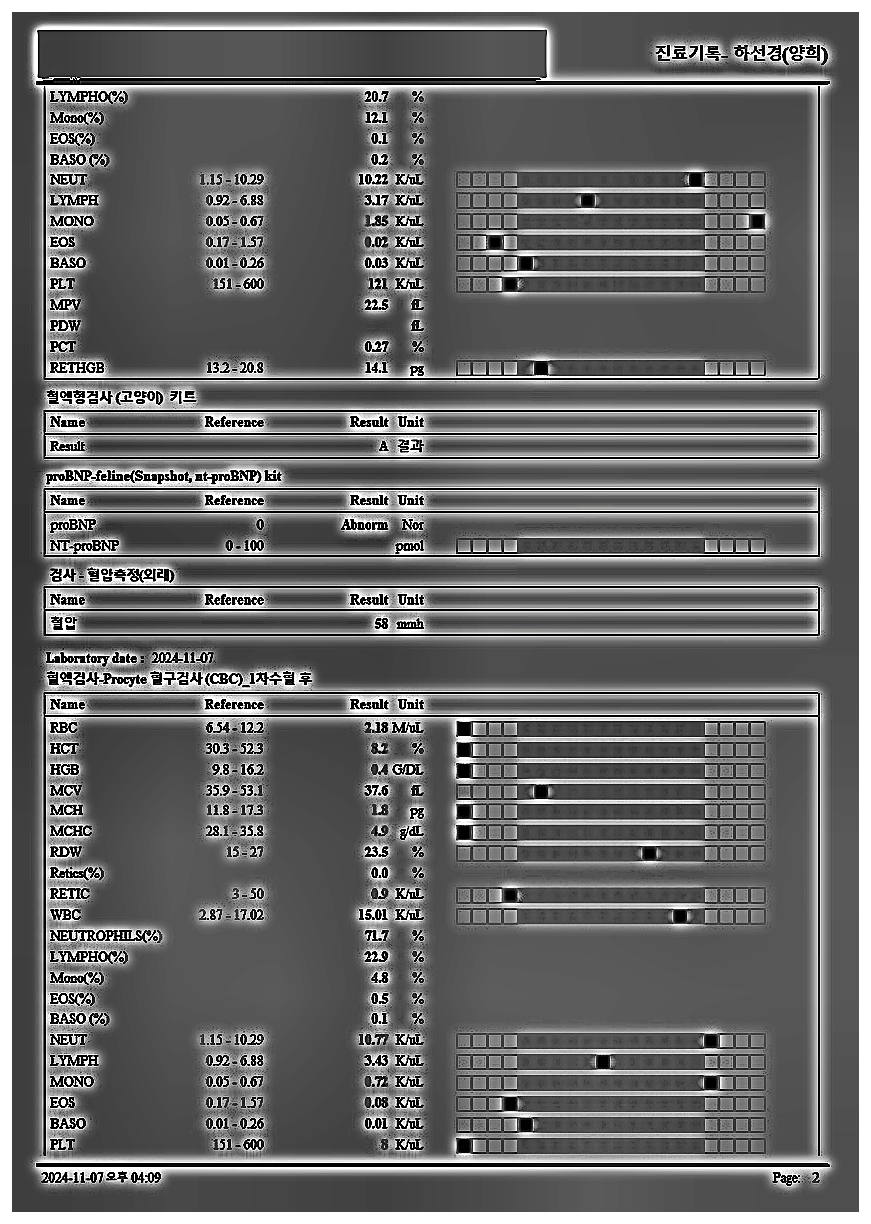


✅ 이미지 전처리 완료!

🔍 OCR 텍스트 추출 시작...

🔬 디버깅: 원본 이미지로 TrOCR 테스트
📥 TrOCR 모델 로드 중: microsoft/trocr-base-printed


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ 모델 로드 완료 (2.8초)
🖥️ 디바이스: cpu
🖼️ 이미지 크기: (794, 1123)
⏱️ 처리 시간: 6.27초
📝 추출된 텍스트 길이: 43자
📄 원본 이미지 TrOCR 결과: 'INVOICE AND RECEIPT FOR EXCLUSIVE TAIDED BY'
📏 원본 텍스트 길이: 43자

🔬 디버깅: 전처리된 이미지로 TrOCR 테스트
✅ 이미 로드된 모델: microsoft/trocr-base-printed
🖼️ 이미지 크기: (871, 1224)
⏱️ 처리 시간: 2.77초
📝 추출된 텍스트 길이: 17자
📄 전처리 이미지 TrOCR 결과: 'AMOUNT RECEIP NO.'
📏 전처리 텍스트 길이: 17자

🔬 디버깅: 최소 전처리로 테스트
✅ 이미 로드된 모델: microsoft/trocr-base-printed
🖼️ 이미지 크기: (794, 1123)
⏱️ 처리 시간: 7.05초
📝 추출된 텍스트 길이: 43자
📄 최소 전처리 TrOCR 결과: 'INVOICE AND RECEIPT FOR EXCLUSIVE TAIDED BY'
📏 최소 전처리 텍스트 길이: 43자

🔬 디버깅: 다국어 모델로 테스트
📥 TrOCR 모델 로드 중: microsoft/trocr-base-handwritten


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ 모델 로드 완료 (3.4초)
🖥️ 디바이스: cpu
🖼️ 이미지 크기: (794, 1123)
⏱️ 처리 시간: 4.85초
📝 추출된 텍스트 길이: 12자
📄 다국어 모델 결과: '5 References'
📏 다국어 모델 텍스트 길이: 12자

🔍 모든 결과 비교

📋 원본 이미지:
  📝 텍스트: 'INVOICE AND RECEIPT FOR EXCLUSIVE TAIDED BY'
  📏 길이: 43자

📋 전처리된 이미지:
  📝 텍스트: 'AMOUNT RECEIP NO.'
  📏 길이: 17자

📋 최소 전처리:
  📝 텍스트: 'INVOICE AND RECEIPT FOR EXCLUSIVE TAIDED BY'
  📏 길이: 43자

📋 다국어 모델:
  📝 텍스트: '5 References'
  📏 길이: 12자

🏆 가장 좋은 결과: 원본 이미지 (43자)

📄 가장 좋은 추출 결과 전체:
INVOICE AND RECEIPT FOR EXCLUSIVE TAIDED BY
💾 최고 결과 저장: debug_output/best_extracted_text_20241107.txt

✅ 디버깅 완료!


In [53]:
import os
import json

print("📂 전처리 및 OCR 테스트")
print("=" * 40)

# 사용자 입력 받기 (data/ 폴더 기본 경로)
filename = input("📄 data/ 폴더 내 파일명을 입력하세요: ").strip()

# 빈 입력 시 기본값 사용
if not filename:
    # filename = "20241121.png"
    filename = "20241107.jpg"
    # filename = "image.png"
    print(f"🔹 기본 파일 사용: {filename}")

# data/ 경로와 결합
file_path = f"../data/{filename}"
print(f"📁 파일 경로: {file_path}")

# 파일 확장자 확인
file_ext = filename.lower().split(".")[-1]
is_pdf = file_ext == "pdf"
is_image = file_ext in ["png", "jpg", "jpeg", "tiff", "bmp"]

print(f"📋 파일 형식: {file_ext.upper()}")

# 이미지 파일 처리
print("🖼️ 이미지 파일 로드 중...")

try:
    # 파일 읽기
    with open(file_path, "rb") as f:
        raw_image_bytes = f.read()

    print(f"📏 원본 이미지 크기: {len(raw_image_bytes):,} bytes")

    # 전처리 실행
    print("\n🔧 전처리 시작...")
    processed_image_bytes = preprocess_for_trocr(raw_image_bytes)

    print(f"📏 전처리된 이미지 크기: {len(processed_image_bytes):,} bytes")

    # 전처리 결과 저장
    output_dir = "debug_output"
    os.makedirs(output_dir, exist_ok=True)

    output_filename = f"preprocessed_{os.path.splitext(filename)[0]}.png"
    output_path = os.path.join(output_dir, output_filename)

    with open(output_path, "wb") as f:
        f.write(processed_image_bytes)

    print(f"💾 전처리 결과 저장: {output_path}")

    # 전처리된 이미지 표시
    from IPython.display import display, Image as IPImage
    display(IPImage(processed_image_bytes))

    print(f"\n✅ 이미지 전처리 완료!")





    # OCR 실행 - 기본 모델만 사용하되 더 상세한 디버깅
    print("\n🔍 OCR 텍스트 추출 시작...")

    # 먼저 전처리 없이 원본으로 테스트
    print("\n🔬 디버깅: 원본 이미지로 TrOCR 테스트")
    print("=" * 50)

    # 원본 이미지로 직접 TrOCR 테스트
    original_result = trocr_extractor.extract_text(raw_image_bytes, "microsoft/trocr-base-printed")
    print(f"📄 원본 이미지 TrOCR 결과: '{original_result['text']}'")
    print(f"📏 원본 텍스트 길이: {len(original_result['text'])}자")

    # 전처리된 이미지로 TrOCR 테스트
    print("\n🔬 디버깅: 전처리된 이미지로 TrOCR 테스트")
    print("=" * 50)

    processed_result = trocr_extractor.extract_text(processed_image_bytes, "microsoft/trocr-base-printed")
    print(f"📄 전처리 이미지 TrOCR 결과: '{processed_result['text']}'")
    print(f"📏 전처리 텍스트 길이: {len(processed_result['text'])}자")

    # 간단한 전처리로 다시 테스트
    print("\n🔬 디버깅: 최소 전처리로 테스트")
    print("=" * 50)

    def minimal_preprocess(img_bytes: bytes) -> bytes:
        """최소한의 전처리만 적용"""
        try:
            img = open_with_exif(img_bytes)
            
            # 기본 정리만
            img = flatten_transparency(img)
            img = normalize_mode(img)
            
            # 해상도만 적당히 조정
            w, h = img.size
            if max(w, h) < 800:
                scale = 800 / max(w, h)
                img = img.resize((int(w * scale), int(h * scale)), Image.LANCZOS)
            
            # 약간의 대비 향상만
            img = weak_autocontrast(img, cutoff=1.0)
            
            return save_png_bytes(img, compress_level=6)
        except Exception as e:
            print(f"⚠️ 최소 전처리 실패: {e}")
            return img_bytes

    minimal_processed = minimal_preprocess(raw_image_bytes)
    minimal_result = trocr_extractor.extract_text(minimal_processed, "microsoft/trocr-base-printed")
    print(f"📄 최소 전처리 TrOCR 결과: '{minimal_result['text']}'")
    print(f"📏 최소 전처리 텍스트 길이: {len(minimal_result['text'])}자")

    # 다른 TrOCR 모델로도 테스트
    print("\n🔬 디버깅: 다국어 모델로 테스트")
    print("=" * 50)

    handwritten_result = trocr_extractor.extract_text(raw_image_bytes, "microsoft/trocr-base-handwritten")
    print(f"📄 다국어 모델 결과: '{handwritten_result['text']}'")
    print(f"📏 다국어 모델 텍스트 길이: {len(handwritten_result['text'])}자")

    # 최종 결과 비교
    print("\n" + "=" * 60)
    print("🔍 모든 결과 비교")
    print("=" * 60)

    results = [
        ("원본 이미지", original_result['text']),
        ("전처리된 이미지", processed_result['text']), 
        ("최소 전처리", minimal_result['text']),
        ("다국어 모델", handwritten_result['text'])
    ]

    best_result = ""
    best_length = 0
    best_method = ""

    for method, text in results:
        print(f"\n📋 {method}:")
        print(f"  📝 텍스트: '{text[:100]}{'...' if len(text) > 100 else ''}'")
        print(f"  📏 길이: {len(text)}자")
        
        if len(text) > best_length:
            best_length = len(text)
            best_result = text
            best_method = method

    print(f"\n🏆 가장 좋은 결과: {best_method} ({best_length}자)")

    if best_result:
        print("\n📄 가장 좋은 추출 결과 전체:")
        print("=" * 60)
        print(best_result)
        print("=" * 60)
        
        # 가장 좋은 결과 저장
        best_output_path = os.path.join(output_dir, f"best_extracted_text_{os.path.splitext(filename)[0]}.txt")
        with open(best_output_path, "w", encoding="utf-8") as f:
            f.write(f"방법: {best_method}\n")
            f.write(f"텍스트 길이: {best_length}자\n")
            f.write("=" * 60 + "\n")
            f.write(best_result)
        print(f"💾 최고 결과 저장: {best_output_path}")

    else:
        print("\n❌ 모든 방법이 실패했습니다.")
        print("💡 제안사항:")
        print("  1. 이미지 해상도가 너무 낮을 수 있습니다")
        print("  2. 이미지가 너무 복잡하거나 노이즈가 많을 수 있습니다")
        print("  3. 텍스트가 TrOCR이 처리하기 어려운 폰트일 수 있습니다")
        print("  4. Tesseract OCR과 비교해보시길 권장합니다")

    print("\n✅ 디버깅 완료!")





except FileNotFoundError:
    print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
except Exception as e:
    print(f"❌ 오류: {e}")
    import traceback
    traceback.print_exc()